# Assignment 7: Image Processing With a CNN  
This assignment follows the same structure as Assignment 6. We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (Links to an external site.). Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation.  
## Management Problem  
Assume that we are providing advice to a website provider who is looking for tools to automatically label images provided by end users. As we look across the factors in the study, making recommendations to management about image classification, we are most concerned about achieving the highest possible accuracy in image classification. That is, we should be willing to sacrifice training time for model accuracy. What type of machine learning model works best? If it is a convolutional neural network, what type of network should we use? Part of this recommendation may concern information about the initial images themselves (input data for the classification task). What types of images work best?

# Setup  & Data Ingest

## Initial Imports

In [1]:
# General purpose libraries
import json
import os, cv2, re, random
import numpy as np
import pandas as pd

# Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K

# Scikit-learn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Load Data

In [2]:
# Create directory for images
!mkdir ~/.kaggle
!mkdir /content/.kaggle

# User token
token = {"username":"YourUsername","key":"YourKey"}

# Save token
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/content/.kaggle’: File exists
- path is now set to: {/content}


In [7]:
# Pull the images from the kaggle api
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p /content
!unzip -q \*.zip

 92% 250M/271M [00:01<00:00, 186MB/s]
100% 271M/271M [00:01<00:00, 198MB/s]
 98% 531M/544M [00:04<00:00, 64.0MB/s]
100% 544M/544M [00:04<00:00, 127MB/s] 
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 108MB/s]

2 archives were successfully processed.


## Data Cleaning

In [0]:
# Create Train & test sets
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'

#img_width = 150
#img_height = 150

img_width = 224
img_height = 224

train_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [0]:
# Helper functions
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [0]:
# Reduce the training size to avoid out of memory error
train_images_dogs_cats.sort(key=natural_keys)
train_images_dogs_cats = train_images_dogs_cats[0:1300] + train_images_dogs_cats[12500:13800] 

test_images_dogs_cats.sort(key=natural_keys)

In [0]:
# Data prep function
def prepare_data(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
        elif 'cat' in i:
            y.append(0)
        #else:
            #print('neither cat nor dog name present in images')
            
    return x, y

In [7]:
# Prep the data
X, Y = prepare_data(train_images_dogs_cats)

# Check backend format for how tensors needs to be fed into model
print(K.image_data_format())

channels_last


## Train / Validation Split

In [0]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=1)

# EDA

In [37]:
# Review tensor shape of traning data
np.array(X).shape

(2600, 224, 224, 3)

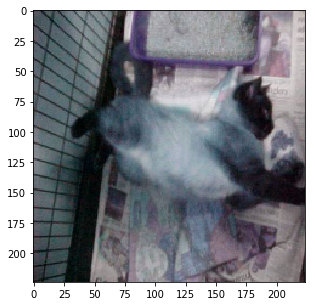

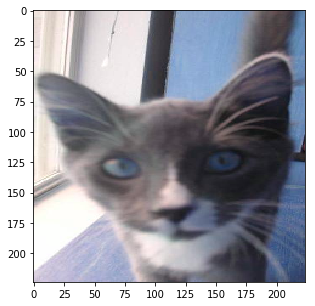

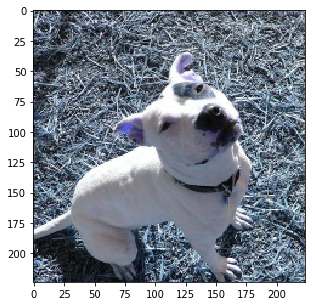

In [39]:
# Plot a few images
def show_cats_and_dogs(idx):
  picture = X_train[idx]
  plt.figure(figsize=(10,5))
  plt.imshow(picture)
  plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

# Modeling

## Convolutional Neural Network (CNN) 1:

### Training

In [0]:
# Create variables for models
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
batch_size = 10

In [9]:
# Build layers for the CNN

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
# Image pre-processing; ImageDataGenerator will incrementall process images and
# feed them to the model to avoid out of memory errors
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [0]:
# Create generators to pass to model
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [28]:
# Run the model (10 epochs)
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/10
208/208 [==============================] - 19s 91ms/step - loss: 0.5093 - acc: 0.7707 - val_loss: 0.5456 - val_acc: 0.7414
Epoch 2/10
208/208 [==============================] - 17s 80ms/step - loss: 0.4999 - acc: 0.7674 - val_loss: 0.5756 - val_acc: 0.7330
Epoch 3/10
208/208 [==============================] - 17s 80ms/step - loss: 0.4745 - acc: 0.7924 - val_loss: 0.5407 - val_acc: 0.7194
Epoch 4/10
208/208 [==============================] - 17s 83ms/step - loss: 0.4697 - acc: 0.7924 - val_loss: 0.5520 - val_acc: 0.7255
Epoch 5/10
208/208 [==============================] - 19s 90ms/step - loss: 0.4572 - acc: 0.7984 - val_loss: 0.5470 - val_acc: 0.7500
Epoch 6/10
208/208 [==============================] - 18s 85ms/step - loss: 0.4439 - acc: 0.7939 - val_loss: 0.7838 - val_acc: 0.7145
Epoch 7/10
208/208 [==============================] - 17s 81ms/step - loss: 0.4375 - acc: 0.8041 - val_loss: 0.4955 - val_acc: 0.7840
Epoch 8/10
208/208 [==============================] - 17s 81ms

### Testing

In [9]:
# Mount google drive and write the dataframe to csv
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Write model and weights to files in case need runtime crashes
model.save_weights('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_one_weights.h5')
model.save('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_one_keras.h5')

In [0]:
# Prep test data
X_test, Y_test = prepare_data(test_images_dogs_cats)

In [0]:
# Create generator for test data; only rescale test data
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [30]:
# Instantiate the generator and pass iterative test data to model for predictions
# output of predictions is a probability that the image is a dog
test_generator = test_datagen.flow(np.array(X_test), batch_size=batch_size)
prediction_probabilities = model.predict_generator(test_generator, verbose=1, steps=len(X_test) // batch_size)

1250/1250 [==============================] - 7s 6ms/step


In [0]:
# Create file for submission
counter = range(1, len(test_images_dogs_cats) + 1)
solution = pd.DataFrame({"id": counter, "label":list(prediction_probabilities)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("/content/gdrive/My Drive/northwestern/422-msds/week-07/dogsVScats_one.csv", index = False)

**Kaggle Score**  
Log Loss = 1.90651

## Convolutional Neural Network (CNN) 2:

### Training

In [43]:
# Build layers for the CNN

model_two = models.Sequential()

model_two.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model_two.add(layers.Activation('relu'))
model_two.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_two.add(layers.Conv2D(32, (3, 3)))
model_two.add(layers.Activation('relu'))
model_two.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_two.add(layers.Conv2D(64, (3, 3)))
model_two.add(layers.Activation('relu'))
model_two.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_two.add(layers.Conv2D(64, (3, 3)))
model_two.add(layers.Activation('relu'))
model_two.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_two.add(layers.Conv2D(128, (3, 3)))
model_two.add(layers.Activation('relu'))
model_two.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_two.add(layers.Flatten())
model_two.add(layers.Dense(128))
model_two.add(layers.Activation('relu'))
model_two.add(layers.Dropout(0.5))

model_two.add(layers.Dense(128))
model_two.add(layers.Activation('relu'))
model_two.add(layers.Dropout(0.5))

model_two.add(layers.Dense(2))
model_two.add(layers.Activation('sigmoid'))

model_two.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model_two.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_36 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_37 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 64)        18496     
__________

In [45]:
# Run the model (10 epochs)
history_two = model_two.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/10
208/208 [==============================] - 18s 86ms/step - loss: 0.6969 - acc: 0.5018 - val_loss: 0.6929 - val_acc: 0.5024
Epoch 2/10
208/208 [==============================] - 18s 85ms/step - loss: 0.6919 - acc: 0.5297 - val_loss: 0.6744 - val_acc: 0.5686
Epoch 3/10
208/208 [==============================] - 17s 81ms/step - loss: 0.6714 - acc: 0.6007 - val_loss: 0.6602 - val_acc: 0.5850
Epoch 4/10
208/208 [==============================] - 18s 88ms/step - loss: 0.6453 - acc: 0.6367 - val_loss: 0.6199 - val_acc: 0.6507
Epoch 5/10
208/208 [==============================] - 16s 79ms/step - loss: 0.6216 - acc: 0.6614 - val_loss: 0.7203 - val_acc: 0.5133
Epoch 6/10
208/208 [==============================] - 17s 80ms/step - loss: 0.6044 - acc: 0.7004 - val_loss: 0.6182 - val_acc: 0.6569
Epoch 7/10
208/208 [==============================] - 17s 81ms/step - loss: 0.5865 - acc: 0.7088 - val_loss: 0.7217 - val_acc: 0.6324
Epoch 8/10
208/208 [==============================] - 18s 85ms

In [0]:
# Write model and weights to files in case need runtime crashes
model.save_weights('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_two_weights.h5')
model.save('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_two_keras.h5')

### Testing

In [47]:
prediction_probabilities = model_two.predict_generator(test_generator, verbose=1, steps=len(X_test) // batch_size)

1250/1250 [==============================] - 6s 5ms/step


In [0]:
solution = pd.DataFrame({"id": counter, "label":list(prediction_probabilities)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("/content/gdrive/My Drive/northwestern/422-msds/week-07/dogsVScats_two.csv", index = False)

**Kaggle Score**  
Log Loss = 1.26014

## Convolutional Neural Network (CNN) 3:

### Training

In [50]:
# Run the model (50 epochs)
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/50
208/208 [==============================] - 17s 83ms/step - loss: 0.4173 - acc: 0.8245 - val_loss: 0.6745 - val_acc: 0.7463
Epoch 2/50
208/208 [==============================] - 17s 80ms/step - loss: 0.3913 - acc: 0.8389 - val_loss: 0.4737 - val_acc: 0.7892
Epoch 3/50
208/208 [==============================] - 18s 84ms/step - loss: 0.3868 - acc: 0.8332 - val_loss: 0.7226 - val_acc: 0.7342
Epoch 4/50
208/208 [==============================] - 19s 94ms/step - loss: 0.3855 - acc: 0.8389 - val_loss: 0.8238 - val_acc: 0.7623
Epoch 5/50
208/208 [==============================] - 17s 81ms/step - loss: 0.3877 - acc: 0.8395 - val_loss: 0.5748 - val_acc: 0.7718
Epoch 6/50
208/208 [==============================] - 17s 81ms/step - loss: 0.4078 - acc: 0.8257 - val_loss: 0.5960 - val_acc: 0.7733
Epoch 7/50
208/208 [==============================] - 17s 81ms/step - loss: 0.3966 - acc: 0.8362 - val_loss: 0.5405 - val_acc: 0.7985
Epoch 8/50
208/208 [==============================] - 18s 87ms

In [0]:
# Write model and weights to files in case need runtime crashes
model.save_weights('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_three_weights.h5')
model.save('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_three_keras.h5')

### Testing

In [52]:
prediction_probabilities = model.predict_generator(test_generator, verbose=1, steps=len(X_test) // batch_size)

1250/1250 [==============================] - 7s 6ms/step


In [0]:
solution = pd.DataFrame({"id": counter, "label":list(prediction_probabilities)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("/content/gdrive/My Drive/northwestern/422-msds/week-07/dogsVScats_three.csv", index = False)

**Kaggle Score**  
Log Loss = 3.63742  
*The model overfit the training data. Having more epochs isn't necessarily a good thing.  We can try adjusting the learning rate and use a different optimizer.*

## Convolutional Neural Network (CNN) 4:

### Training

In [24]:
# Build layers for the CNN

optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_6 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 32)        0         
___________________________

In [26]:
# Run the model (20 epochs)
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/50
208/208 [==============================] - 24s 117ms/step - loss: 0.5339 - acc: 0.7197 - val_loss: 0.5608 - val_acc: 0.7173
Epoch 2/50
208/208 [==============================] - 23s 112ms/step - loss: 0.5335 - acc: 0.7317 - val_loss: 0.5305 - val_acc: 0.7327
Epoch 3/50
208/208 [==============================] - 24s 118ms/step - loss: 0.5023 - acc: 0.7462 - val_loss: 0.5464 - val_acc: 0.7096
Epoch 4/50
208/208 [==============================] - 23s 111ms/step - loss: 0.4997 - acc: 0.7543 - val_loss: 0.5359 - val_acc: 0.7250
Epoch 5/50
208/208 [==============================] - 23s 111ms/step - loss: 0.5132 - acc: 0.7462 - val_loss: 0.5189 - val_acc: 0.7231
Epoch 6/50
208/208 [==============================] - 23s 112ms/step - loss: 0.4972 - acc: 0.7582 - val_loss: 0.5255 - val_acc: 0.7327
Epoch 7/50
208/208 [==============================] - 26s 123ms/step - loss: 0.4694 - acc: 0.7692 - val_loss: 0.5295 - val_acc: 0.7423
Epoch 8/50
208/208 [==============================] - 2

In [0]:
# Write model and weights to files in case need runtime crashes
model.save_weights('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_four_weights.h5')
model.save('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_four_keras.h5')

### Testing

In [0]:
# Load model after memory error
from keras.models import load_model

In [13]:
# Load model from file (due to memory error)
model = load_model('/content/gdrive/My Drive/northwestern/422-msds/week-07/model_four_keras.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [16]:
# Instantiate the generator and pass iterative test data to model for predictions
# output of predictions is a probability that the image is a dog
test_generator = test_datagen.flow(np.array(X_test), batch_size=batch_size)
prediction_probabilities = model.predict_generator(test_generator, verbose=1, steps=len(X_test) // batch_size)

1250/1250 [==============================] - 14s 11ms/step


In [0]:
counter = range(1, len(test_images_dogs_cats) + 1)
solution = pd.DataFrame({"id": counter, "label":list(prediction_probabilities)})
cols = ['label']

for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

solution.to_csv("/content/gdrive/My Drive/northwestern/422-msds/week-07/dogsVScats_four.csv", index = False)

**Kaggle Score**  
Log Loss = 2.51124

In [0]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

In [0]:
plot_model(model, to_file="/content/gdrive/My Drive/northwestern/422-msds/week-07/model_four.png")

# Summary

In [47]:
# Create summary dataframe of parameters
summary_df = pd.DataFrame(
    {
        "Model": [1, 2, 3, 4],
        "Optimizer": ["RMSProp", "RMSProp", "RMSProp", "SGD"],
        "ConvolutionalLayers": [3, 5, 3, 3],
        "PoolingLayers": [3, 5, 3, 3],
        "DenseLayers": [2, 3, 2, 2],
        "Epochs": [10,10,50,50],
        "TrainingAccuracy": [0.8062, 0.7392, 0.8531, 0.9356],
        "ValidationAccuracy": [0.7598, 0.7476, 0.7718, 0.7635],
        "LogLossTestKaggle": [1.90651, 1.26014, 3.63742, 2.51124]
    }
)

summary_df

,Model,Optimizer,ConvolutionalLayers,PoolingLayers,DenseLayers,Epochs,TrainingAccuracy,ValidationAccuracy,LogLossTestKaggle
0,1,RMSProp,3,3,2,10,0.8062,0.7598,1.90651
1,2,RMSProp,5,5,3,10,0.7392,0.7476,1.26014
2,3,RMSProp,3,3,2,50,0.8531,0.7718,3.63742
3,4,SGD,3,3,2,50,0.9356,0.7635,2.51124


Text(0.5, 1.0, 'Log Loss by Model')

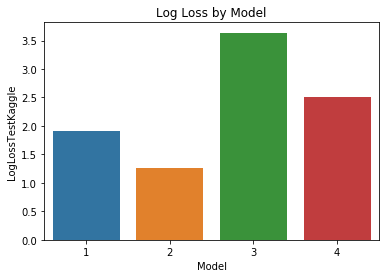

In [46]:
import seaborn as sns
sns.barplot(summary_df["Model"], summary_df["LogLossTestKaggle"]).set_title("Log Loss by Model")

# Conclusion  
Management should consider utilizing a convolutional neural network (CNN) for their image classifcation problem.  Four CNNs were trained with various hyper parameters.  The deepest CNN trained yielded the best Log Loss on the test data (1.26014).  This particular model was trained on a subset of the images in order to reduce the amount of time and resources needed.  Greater accuracy could be achieved by training the CNN on the full training set.  The .jpg image files can be preprocessed in a data pipeline and incrementally transformed and fed to the model for classification.  Further reserach would need to be conducted to judge the effectiveness of different image file types (i.e. .png)